### Initilization

In [1]:
import pypsa
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np

### Scenarios

In [2]:
# --------- 1) Scenarios  ----------
# base:   grid connection
#         CHP 0.635 MW_el, 0.79 MW_th
#         solar_freefield 0.840 MWp
#         nothing extendable
# 2:      grid connection
#         CHP 0.635 MW_el, 0.79 MW_th
#         solar_freefield 0.840 MWp
#         elec flow storage 0.72MWh, 0.12MW
#         nothing extendable
# 3:      grid connection
#         CHP 0.635 MW_el, 0.79 MW_th
#         solar_freefield 0.840 MWp
#         elec flow storage 0.72MWh, 0.12MW
#         rooftop PV extendable
# 4:      No grid connection
#         CHP extendable
#         solar_freefield 0.840 MWp
#         elec flow storage extendable
#         rooftop PV extendable
# 5:      No grid connection
#         CHP extendable
#         solar_freefield 0.840 MWp
#         elec flow storage extendable
#         rooftop PV extendable
#         wind extendable

pars = {
    1: dict(grid=True,  chp_ext=False, solar_roof=False, flow_storage=False, flow_storage_ext=False, wind=False),
    2: dict(grid=True,  chp_ext=False, solar_roof=False, flow_storage=True,  flow_storage_ext=False, wind=False),
    3: dict(grid=True,  chp_ext=False, solar_roof=True,  flow_storage=True,  flow_storage_ext=False, wind=False),
    4: dict(grid=False, chp_ext=True,  solar_roof=True,  flow_storage=True,  flow_storage_ext=True,  wind=False),
    5: dict(grid=False, chp_ext=True,  solar_roof=True,  flow_storage=True,  flow_storage_ext=True,  wind=True)
}

wd = "/home/cs/Documents/Cola/Master/MS_5-Semester/AU-Viborg" # working directory

### Data

In [37]:
# Interest rate
ir = 0.07

# Raw cost data
# heat storage (watertank) assumptions: 127L, ΔT 40 K, usable fraction 1, p_nom=5kWh, 172000 eur/MWh = 16200 eur/MWh annulized
data = pd.DataFrame({
    "capex": [400e3, 1000e3, 1100e3, 400e3, 500e3, 172e3, 0],  # eur/MWp eur/L
    "FOM": [10e3, 12e3, 14e3, 14e3, 10e3, 0, 0],  # Fixed O&M (€/MWp/year)
    "opex": [0, 0, 0.05e3, 0.17e3, 0, 0, 0.35e3],  # Variable O&M (€/MWh)
    "lifetime": [35, 35, 27, 20, 20, 20, 1],  # Grid lifetime=1 to avoid div/0
}, index=["PVFree", "PVRoof", "onwind", "CHP", "flow_storage", "thermal_storage", "grid"])

# Annualize CAPEX and add FOM
# For technologies with capital investment: annualized_capex = CAPEX * CRF + FOM
# CRF (Capital Recovery Factor) = ir*(1+ir)^n / ((1+ir)^n - 1)
data["capex_annual"] = data["capex"] * (ir * (1 + ir)**data["lifetime"] / 
                                         ((1 + ir)**data["lifetime"] - 1)) + data["FOM"]

# Grid costs need special handling
# Since PyPSA optimizes per year, we treat the 40 €/kW as an annual capacity cost
grid_capacity_cost = 40e3  # €/MW annual capacity charge
grid_energy_cost = 0.35e3  # €/MWh energy charge

# Wind timeseries
wind_ts = pd.read_csv(f"{wd}/data/Wind_Vestas-V90-2000_2019.csv", comment="#")
wind_ts = wind_ts.set_index("time")
wind_ts.index = pd.to_datetime(wind_ts.index)
wind_ts = wind_ts.drop(columns=["local_time"])
wind_ts["CF"] = wind_ts["electricity"]/2000 # 2000 rated power

# Solar timeseries
solar_dict = {'SE': 2.003, 'S': 1.056, 'SW': 6.643, 'E': 0.731, 'NW': 2.003, 'N': 1.056, 'NE': 6.643, 'W': 0.731, 'FF': 0.84} #MW
solar_ts_dict = {}
for loc in solar_dict:  # loop directly over dictionary keys
    files = glob.glob(f"{wd}/data/Solar_{loc}_*.csv")
    if not files:
        continue
    ts = pd.read_csv(files[0], skiprows=10, skipfooter=11, engine="python")
    ts["time"] = pd.to_datetime(ts["time"].str.replace(":", ""), format="%Y%m%d%H%M")
    ts["time"] = ts["time"].dt.floor("h")
    ts = ts.set_index("time")
    # Compute capacity factor using the dictionary
    solar_ts_dict[loc] = ts["P"] / (solar_dict[loc] * 1e6)
solar_ts = pd.DataFrame(solar_ts_dict) # Combine all location series into one DataFrame

# Heat demand timeseries
L_h = pd.read_excel(f"{wd}/data/Synthese_von_Waermelastprofilen_nach_BDEW.xlsx", sheet_name="Ausgabe")
#L_h["Energie in kWh"].sum() # check if it is 626.57 m3 * 10.16 kWh/m3 = 6365.95 kWh as given in the data
L_h = L_h.rename(columns={"Zeitstempel": "time", "Energie in kWh": "energy"})
L_h = L_h.set_index('time')
L_h.index = pd.to_datetime(L_h.index, unit='h')
L_h.index = L_h.index - pd.DateOffset(years=4) #match 2019 timestamp
L_h = L_h.iloc[:-24] # drop the day after newyears
L_h = L_h/L_h.sum() # normalize 
#L_h = L_h*(626573*0.01016) # new timeseries from known total yearly load
L_h = L_h*(626573*0.01016)/2 # heatload = 0.5 gas consumption

# Power Demand Timeseries
# Based on that there as of now is no CHP (so full elec demand as given by Björn)
L_e = pd.read_excel(f"{wd}/data/N61616_sum_alle_3.xlsx")
L_e = L_e.iloc[:, [4,8]]
L_e = L_e.rename(columns={"Gældende fra": "time", "Sum 61616 ": "energy"}) 
L_e['time'] = pd.to_datetime(L_e['time']).dt.tz_localize("Europe/Copenhagen", ambiguous="NaT", nonexistent="NaT")
L_e['time'] = L_e['time'].dt.tz_convert("UTC")
L_e.index = L_e["time"]
L_e = L_e.drop('time', axis=1)
last_row = L_e.iloc[[-1]].copy()
last_row.index = last_row.index + pd.Timedelta(hours=1)
L_e = pd.concat([L_e, last_row])
L_e.index = wind_ts.index
L_e = L_e/L_e.sum() # normalize to total value
# L_e = L_e*5357.924 # use normalized profile times known yearly sum to get timeseries in kWh
L_e = L_e * (5357.924 + 0.4*(626573*0.01016)) # elecload = elecload+40%gas consumption

### Network setup

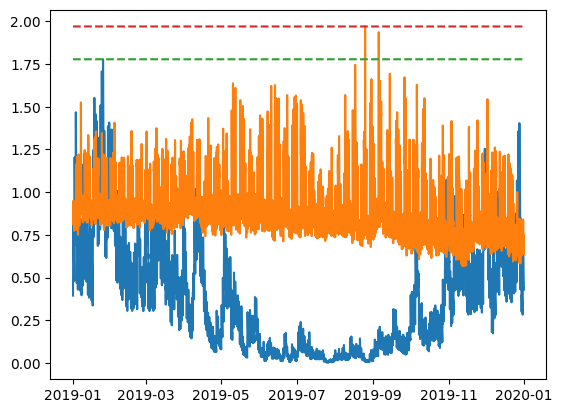

In [38]:
# davon ausgehdend das AU-Viborg zum jetztigen zeitpunkt noch kein CHP hat sind gasverbrauch = heizlast.
# damit muss die chp anlage grösser dimensioniert werden als vom fraunehofer angenommen. nämlich L_h.max()
plt.plot(L_h, label="L_h")
plt.plot(L_e, label="L_e")
plt.plot(L_h.index, np.full(len(L_h), L_h.max()), '--', label="L_h max")
plt.plot(L_h.index, np.full(len(L_e), L_e.max()), '--', label="L_e max")
#plt.legend()
plt.show()

In [39]:
# Choose Scenario
SC = 3 # 1,2,3,4,5
cfg = pars[SC]

In [43]:
scenarios = [1,2,3,4,5]
for SC in scenarios:
      cfg = pars[SC]
      # --------- Setup Network ----------
      n = pypsa.Network()
      n.set_snapshots(wind_ts.index)

      # Buses
      n.add("Bus", "elec")
      n.add("Bus", "heat")
      n.add("Bus", "gas")

      # Loads (use your actual load data)
      n.add("Load", "L_e", bus="elec", p_set=L_e["energy"])
      n.add("Load", "L_h", bus="heat", p_set=L_h["energy"])

      # --------- Generators ----------
      # Grid import
      if cfg.get("grid") == True:
            n.add("Carrier", "grid")
            n.add("Generator",
                  "grid_import",
                  bus="elec",
                  carrier="grid",
                  p_nom_extendable=True,
                  p_nom_max=1e12,
                  marginal_cost=grid_energy_cost,  # 0.35e3 eur/MWh
                  capital_cost=grid_capacity_cost)  # 40e3 eur/MW annual

      # Grid electricity export (elec dump)
      n.add("Generator",
            "grid_export",
            bus="elec",
            carrier="grid",
            sign=-1,
            p_nom=1e12,
            p_nom_extendable=True)

      # Solar freefield
      n.add("Carrier", "solar_ff")
      n.add("Generator",
            "solar_S_ff",
            bus="elec",
            carrier="solar_ff",
            p_max_pu=solar_ts["FF"],
            capital_cost=data.at["PVFree", "capex_annual"],
            p_nom_min=0.84,
            p_nom_extendable=True,
            p_nom_max=0.84) #MWp

      # Solar generators (rooftop)
      n.add("Carrier", "solar_rt")
      if cfg.get("solar_roof") == True:
            for loc in solar_ts.columns:
                  if loc == "FF":
                        continue
                  n.add("Generator",
                        f"solar_{loc}_rt",
                        bus="elec",
                        carrier="solar_rt",
                        p_max_pu=solar_ts[loc],
                        capital_cost=data.at["PVRoof", "capex_annual"],
                        p_nom_extendable=True,
                        p_nom_max=solar_dict[loc])

      # Wind
      if cfg.get("wind") == True:
            n.add("Carrier", "wind")
            n.add("Generator",
                  "wind",
                  bus="elec",
                  carrier="wind",
                  p_max_pu=wind_ts["CF"],
                  capital_cost=data.at["onwind", "capex_annual"],
                  p_nom_extendable=True,)
                  #p_nom_max=2) # own estimate

      # Biogas supply
      n.add("Carrier", "biogas")
      n.add("Generator",
            "biogas_supply",
            bus="gas",
            carrier="biogas",
            p_nom=1e12,
            marginal_cost=0)  # Cost is in CHP operation

      # --------- Links ----------
      # CHP: gas -> electricity (40%) + heat (50%)
      n.add("Carrier", "CHP")
      n.add("Link",
            "CHP",
            carrier="CHP",
            bus0="gas",
            bus1="elec",
            bus2="heat",
            #p_nom_min=float(L_h.max())/0.5*1.01,   #1.5875,  # 0.635 MW_el / 0.4 ..... float(L_h.max())/0.5
            efficiency=0.40,
            efficiency2=0.50,
            capital_cost=data.at["CHP", "capex_annual"],  # eur/MW_th/year
            marginal_cost=data.at["CHP", "opex"],  # 0.17e3 eur/MWh biogas cost
            p_nom_extendable=True) #cfg.get("chp_ext"))

      # heat storage (watertank)
      # assumptions: 127L, ΔT 40 K, usable fraction 1, p_nom=5kWh, 172000 eur/MWh = 16200 eur/MWh annulized
      n.add("Carrier", "heat_storage")
      n.add("StorageUnit",
      "heat_storage",
      bus="heat",
      carrier="heat_storage",
      max_hours=1.182,
      p_nom=0.005, #5kWh
      capital_cost=data.at["thermal_storage", "capex_annual"],
      efficiency_store=0.95,
      efficiency_dispatch=0.95,
      standing_loss=0.01, #99% efficient
      p_nom_extendable=False,
      cyclic_state_of_charge=True,
      )

      # heatsink (dump heat)
      n.add("Carrier", "heat_sink")
      n.add("StorageUnit",
      "heat_sink",
      bus="heat",
      carrier="heat_sink",
      max_hours=1e12,
      p_nom=1e12,
      capital_cost=0,
      efficiency_store=1,
      efficiency_dispatch=0.0001,
      standing_loss=1,
      p_nom_extendable=True,
      cyclic_state_of_charge=True,
      )

      # --------- Storage ----------
      # Flow storage (battery) - using Store + Links
      # Store: holds energy (€/MWh cost)
      # Links: charge and discharge (€/kW cost)
      if cfg.get("flow_storage") == True:
            n.add("Bus", "battery")

            # Add the Store (energy capacity)
            n.add("Carrier", "flow_storage")
            n.add("Store",
                  "flow_storage",
                  carrier="flow_storage",
                  bus="battery",
                  e_nom=0.72,  # Energy capacity in MWh
                  e_cyclic=True,  # State of charge is cyclic (end = start)
                  capital_cost= data.at["flow_storage", "capex_annual"],  # €/MWh/year
                  e_nom_extendable=cfg.get("flow_storage_ext"))

            # Add charging Link (grid -> battery)
            n.add("Link",
                  "flow_storage_charge",
                  carrier="flow_storage",
                  bus0="elec",
                  bus1="battery",
                  p_nom=0.12,  # Charging power in MW
                  efficiency=0.9,  # Charging efficiency
                  capital_cost=0)  # €/MW/year for charging
                  #p_nom_extendable=cfg.get("flow_storage_ext"))

            # Add discharging Link (battery -> grid)
            n.add("Link",
                  "flow_storage_discharge",
                  carrier="flow_storage",
                  bus0="battery",
                  bus1="elec",
                  p_nom=0.12,  # Discharging power in MW
                  efficiency=0.9,  # Discharging efficiency
                  capital_cost=0)  # €/MW/year for discharging
                  #p_nom_extendable=cfg.get("flow_storage_ext"))
      
      # network.add("Carrier", "gas", co2_emissions=0.19) # in t_CO2/MWh_th
      # co2_limit=4000000 #tonCO2
      # network.add("GlobalConstraint",
      #             "co2_limit",
      #             type="primary_energy",
      #             carrier_attribute="co2_emissions",
      #             sense="<=",
      #             constant=co2_limit)


      n.optimize(solver_name='gurobi', keep_files=False)
      n.export_to_netcdf(f"{wd}/networks/scenario_{SC}_solved.nc")



Index(['elec', 'heat', 'gas'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 179.00it/s]
INFO:linopy.io: Writing time: 1.14s


Set parameter WLSAccessID


INFO:gurobipy:Set parameter WLSAccessID


Set parameter WLSSecret


INFO:gurobipy:Set parameter WLSSecret


Set parameter LicenseID to value 2432370


INFO:gurobipy:Set parameter LicenseID to value 2432370


Academic license 2432370 - for non-commercial use only - registered to 20___@post.au.dk


INFO:gurobipy:Academic license 2432370 - for non-commercial use only - registered to 20___@post.au.dk


Read LP format model from file /tmp/linopy-problem-bzfql0_b.lp


INFO:gurobipy:Read LP format model from file /tmp/linopy-problem-bzfql0_b.lp


Reading time = 0.49 seconds


INFO:gurobipy:Reading time = 0.49 seconds


obj: 236527 rows, 96365 columns, 407012 nonzeros


INFO:gurobipy:obj: 236527 rows, 96365 columns, 407012 nonzeros


Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 24.04.3 LTS")


INFO:gurobipy:Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 24.04.3 LTS")


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i7-5600U CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Core(TM) i7-5600U CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 2 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 2 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Academic license 2432370 - for non-commercial use only - registered to 20___@post.au.dk


INFO:gurobipy:Academic license 2432370 - for non-commercial use only - registered to 20___@post.au.dk


Optimize a model with 236527 rows, 96365 columns and 407012 nonzeros


INFO:gurobipy:Optimize a model with 236527 rows, 96365 columns and 407012 nonzeros


Model fingerprint: 0x612522b3


INFO:gurobipy:Model fingerprint: 0x612522b3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-05, 1e+12]


INFO:gurobipy:  Matrix range     [1e-05, 1e+12]


  Objective range  [2e+02, 5e+04]


INFO:gurobipy:  Objective range  [2e+02, 5e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e-03, 1e+12]


INFO:gurobipy:  RHS range        [4e-03, 1e+12]


INFO:gurobipy:Warning: Model contains large matrix coefficient range


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 194001 rows and 53200 columns


INFO:gurobipy:Presolve removed 194001 rows and 53200 columns


Presolve time: 0.33s


INFO:gurobipy:Presolve time: 0.33s


Presolved: 42526 rows, 43165 columns, 111014 nonzeros


INFO:gurobipy:Presolved: 42526 rows, 43165 columns, 111014 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 2


INFO:gurobipy: Dense cols : 2


 AA' NZ     : 6.785e+04


INFO:gurobipy: AA' NZ     : 6.785e+04


 Factor NZ  : 3.928e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 3.928e+05 (roughly 40 MB of memory)


 Factor Ops : 5.934e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.934e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.20205072e+17 -2.37920810e+19  2.30e+11 1.82e-12  1.14e+14     1s


INFO:gurobipy:   0   1.20205072e+17 -2.37920810e+19  2.30e+11 1.82e-12  1.14e+14     1s


   1   1.45267557e+17 -6.95722109e+18  2.02e+11 1.03e+04  1.08e+14     1s


INFO:gurobipy:   1   1.45267557e+17 -6.95722109e+18  2.02e+11 1.03e+04  1.08e+14     1s


   2   1.53410848e+17 -9.18251554e+18  9.37e+09 1.35e+03  8.99e+13     1s


INFO:gurobipy:   2   1.53410848e+17 -9.18251554e+18  9.37e+09 1.35e+03  8.99e+13     1s


   3   1.22905845e+17 -1.75515317e+16  2.48e+07 2.36e-11  1.27e+12     1s


INFO:gurobipy:   3   1.22905845e+17 -1.75515317e+16  2.48e+07 2.36e-11  1.27e+12     1s


INFO:gurobipy:


Barrier performed 3 iterations in 0.72 seconds (0.34 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.72 seconds (0.34 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   16323    2.9468810e+06   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   16323    2.9468810e+06   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 16323 iterations and 0.94 seconds (0.44 work units)


INFO:gurobipy:Solved in 16323 iterations and 0.94 seconds (0.44 work units)


Optimal objective  2.946880989e+06


INFO:gurobipy:Optimal objective  2.946880989e+06


INFO:gurobipy:Warning: environment still referenced so free is deferred (Continue to use WLS)
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96365 primals, 236527 duals
Objective: 2.95e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:pypsa.network.io:Exported network 

Set parameter WLSAccessID


INFO:gurobipy:Set parameter WLSAccessID


Set parameter WLSSecret


INFO:gurobipy:Set parameter WLSSecret


Set parameter LicenseID to value 2432370


INFO:gurobipy:Set parameter LicenseID to value 2432370


Academic license 2432370 - for non-commercial use only - registered to 20___@post.au.dk


INFO:gurobipy:Academic license 2432370 - for non-commercial use only - registered to 20___@post.au.dk


Read LP format model from file /tmp/linopy-problem-4gxhzhfk.lp


INFO:gurobipy:Read LP format model from file /tmp/linopy-problem-4gxhzhfk.lp


Reading time = 0.64 seconds


INFO:gurobipy:Reading time = 0.64 seconds


obj: 306607 rows, 131405 columns, 529652 nonzeros


INFO:gurobipy:obj: 306607 rows, 131405 columns, 529652 nonzeros


Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 24.04.3 LTS")


INFO:gurobipy:Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 24.04.3 LTS")


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i7-5600U CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Core(TM) i7-5600U CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 2 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 2 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Academic license 2432370 - for non-commercial use only - registered to 20___@post.au.dk


INFO:gurobipy:Academic license 2432370 - for non-commercial use only - registered to 20___@post.au.dk


Optimize a model with 306607 rows, 131405 columns and 529652 nonzeros


INFO:gurobipy:Optimize a model with 306607 rows, 131405 columns and 529652 nonzeros


Model fingerprint: 0x51a02dbe


INFO:gurobipy:Model fingerprint: 0x51a02dbe


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-05, 1e+12]


INFO:gurobipy:  Matrix range     [1e-05, 1e+12]


  Objective range  [2e+02, 5e+04]


INFO:gurobipy:  Objective range  [2e+02, 5e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e-03, 1e+12]


INFO:gurobipy:  RHS range        [4e-03, 1e+12]


INFO:gurobipy:Warning: Model contains large matrix coefficient range


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 254661 rows and 61784 columns


INFO:gurobipy:Presolve removed 254661 rows and 61784 columns


Presolve time: 0.42s


INFO:gurobipy:Presolve time: 0.42s


Presolved: 51946 rows, 69621 columns, 164597 nonzeros


INFO:gurobipy:Presolved: 51946 rows, 69621 columns, 164597 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 2


INFO:gurobipy: Dense cols : 2


 AA' NZ     : 8.637e+04


INFO:gurobipy: AA' NZ     : 8.637e+04


 Factor NZ  : 6.487e+05 (roughly 50 MB of memory)


INFO:gurobipy: Factor NZ  : 6.487e+05 (roughly 50 MB of memory)


 Factor Ops : 8.720e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.720e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.22482072e+17 -2.39952683e+19  2.30e+11 3.87e-07  1.13e+14     1s


INFO:gurobipy:   0   1.22482072e+17 -2.39952683e+19  2.30e+11 3.87e-07  1.13e+14     1s


   1   1.48094222e+17 -7.02299292e+18  2.02e+11 1.01e+04  1.04e+14     1s


INFO:gurobipy:   1   1.48094222e+17 -7.02299292e+18  2.02e+11 1.01e+04  1.04e+14     1s


   2   1.60440914e+17 -5.53356218e+19  1.43e+10 5.65e+03  3.42e+14     1s


INFO:gurobipy:   2   1.60440914e+17 -5.53356218e+19  1.43e+10 5.65e+03  3.42e+14     1s


   3   1.46997704e+17 -2.18320182e+17  7.86e+07 4.40e+00  2.26e+12     1s


INFO:gurobipy:   3   1.46997704e+17 -2.18320182e+17  7.86e+07 4.40e+00  2.26e+12     1s


   4   5.60168913e+15 -1.18298293e+15  5.96e+05 5.12e-08  4.13e+10     1s


INFO:gurobipy:   4   5.60168913e+15 -1.18298293e+15  5.96e+05 5.12e-08  4.13e+10     1s


   5   1.19781225e+13 -1.35116976e+12  6.80e+02 1.11e-08  8.10e+07     1s


INFO:gurobipy:   5   1.19781225e+13 -1.35116976e+12  6.80e+02 1.11e-08  8.10e+07     1s


   6   1.19803889e+10 -1.45865756e+09  3.05e-05 1.27e-11  8.14e+04     1s


INFO:gurobipy:   6   1.19803889e+10 -1.45865756e+09  3.05e-05 1.27e-11  8.14e+04     1s


   7   1.03949782e+07 -7.75595595e+06  3.05e-05 7.52e-12  1.10e+02     1s


INFO:gurobipy:   7   1.03949782e+07 -7.75595595e+06  3.05e-05 7.52e-12  1.10e+02     1s


   8   4.79391083e+06  1.38157030e+06  3.05e-05 5.24e-10  2.07e+01     1s


INFO:gurobipy:   8   4.79391083e+06  1.38157030e+06  3.05e-05 5.24e-10  2.07e+01     1s


   9   4.52396335e+06  2.03649356e+06  3.05e-05 2.91e-10  1.51e+01     2s


INFO:gurobipy:   9   4.52396335e+06  2.03649356e+06  3.05e-05 2.91e-10  1.51e+01     2s


  10   4.34547637e+06  2.22211834e+06  3.05e-05 1.67e-10  1.29e+01     2s


INFO:gurobipy:  10   4.34547637e+06  2.22211834e+06  3.05e-05 1.67e-10  1.29e+01     2s


  11   4.30173107e+06  2.32289007e+06  6.10e-05 1.16e-10  1.20e+01     2s


INFO:gurobipy:  11   4.30173107e+06  2.32289007e+06  6.10e-05 1.16e-10  1.20e+01     2s


  12   3.64374116e+06  2.62106366e+06  3.05e-05 1.75e-10  6.20e+00     2s


INFO:gurobipy:  12   3.64374116e+06  2.62106366e+06  3.05e-05 1.75e-10  6.20e+00     2s


  13   3.20146050e+06  2.74896620e+06  3.05e-05 3.78e-12  2.74e+00     2s


INFO:gurobipy:  13   3.20146050e+06  2.74896620e+06  3.05e-05 3.78e-12  2.74e+00     2s


INFO:gurobipy:


Barrier performed 13 iterations in 2.06 seconds (0.78 work units)


INFO:gurobipy:Barrier performed 13 iterations in 2.06 seconds (0.78 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   42316    2.9401495e+06   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   42316    2.9401495e+06   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 42316 iterations and 2.26 seconds (0.90 work units)


INFO:gurobipy:Solved in 42316 iterations and 2.26 seconds (0.90 work units)


Optimal objective  2.940149549e+06


INFO:gurobipy:Optimal objective  2.940149549e+06


INFO:gurobipy:Warning: environment still referenced so free is deferred (Continue to use WLS)
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 131405 primals, 306607 duals
Objective: 2.94e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balanc

Set parameter WLSAccessID


INFO:gurobipy:Set parameter WLSAccessID


Set parameter WLSSecret


INFO:gurobipy:Set parameter WLSSecret


Set parameter LicenseID to value 2432370


INFO:gurobipy:Set parameter LicenseID to value 2432370


Academic license 2432370 - for non-commercial use only - registered to 20___@post.au.dk


INFO:gurobipy:Academic license 2432370 - for non-commercial use only - registered to 20___@post.au.dk


Read LP format model from file /tmp/linopy-problem-uk1yxby5.lp


INFO:gurobipy:Read LP format model from file /tmp/linopy-problem-uk1yxby5.lp


Reading time = 0.90 seconds


INFO:gurobipy:Reading time = 0.90 seconds


obj: 446783 rows, 201493 columns, 772236 nonzeros


INFO:gurobipy:obj: 446783 rows, 201493 columns, 772236 nonzeros


Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 24.04.3 LTS")


INFO:gurobipy:Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 24.04.3 LTS")


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i7-5600U CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Core(TM) i7-5600U CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 2 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 2 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Academic license 2432370 - for non-commercial use only - registered to 20___@post.au.dk


INFO:gurobipy:Academic license 2432370 - for non-commercial use only - registered to 20___@post.au.dk


Optimize a model with 446783 rows, 201493 columns and 772236 nonzeros


INFO:gurobipy:Optimize a model with 446783 rows, 201493 columns and 772236 nonzeros


Model fingerprint: 0xc8c52165


INFO:gurobipy:Model fingerprint: 0xc8c52165


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-05, 1e+12]


INFO:gurobipy:  Matrix range     [1e-05, 1e+12]


  Objective range  [2e+02, 9e+04]


INFO:gurobipy:  Objective range  [2e+02, 9e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e-03, 1e+12]


INFO:gurobipy:  RHS range        [4e-03, 1e+12]


INFO:gurobipy:Warning: Model contains large matrix coefficient range


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 394837 rows and 131864 columns


INFO:gurobipy:Presolve removed 394837 rows and 131864 columns


Presolve time: 0.61s


INFO:gurobipy:Presolve time: 0.61s


Presolved: 51946 rows, 69629 columns, 196029 nonzeros


INFO:gurobipy:Presolved: 51946 rows, 69629 columns, 196029 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 10


INFO:gurobipy: Dense cols : 10


 AA' NZ     : 1.178e+05


INFO:gurobipy: AA' NZ     : 1.178e+05


 Factor NZ  : 8.085e+05 (roughly 60 MB of memory)


INFO:gurobipy: Factor NZ  : 8.085e+05 (roughly 60 MB of memory)


 Factor Ops : 1.586e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.586e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.38544184e+17 -1.37777130e+20  2.30e+11 8.72e+02  6.42e+14     1s


INFO:gurobipy:   0   1.38544184e+17 -1.37777130e+20  2.30e+11 8.72e+02  6.42e+14     1s


   1   1.63001942e+17 -4.42209641e+19  2.03e+11 6.03e+04  5.97e+14     1s


INFO:gurobipy:   1   1.63001942e+17 -4.42209641e+19  2.03e+11 6.03e+04  5.97e+14     1s


   2   1.45933209e+17 -2.40114845e+20  1.78e+11 4.06e+04  8.54e+14     1s


INFO:gurobipy:   2   1.45933209e+17 -2.40114845e+20  1.78e+11 4.06e+04  8.54e+14     1s


   3   1.58174959e+17 -1.55165379e+20  1.37e+11 1.81e+04  7.34e+14     1s


INFO:gurobipy:   3   1.58174959e+17 -1.55165379e+20  1.37e+11 1.81e+04  7.34e+14     1s


   4   1.64509556e+17 -1.25790397e+20  1.17e+11 1.33e+04  6.71e+14     1s


INFO:gurobipy:   4   1.64509556e+17 -1.25790397e+20  1.17e+11 1.33e+04  6.71e+14     1s


   5   1.80922783e+17 -6.42653713e+19  8.28e+10 7.47e+03  4.45e+14     1s


INFO:gurobipy:   5   1.80922783e+17 -6.42653713e+19  8.28e+10 7.47e+03  4.45e+14     1s


   6   1.95022497e+17 -4.55766785e+18  4.46e+10 3.80e+01  1.09e+14     2s


INFO:gurobipy:   6   1.95022497e+17 -4.55766785e+18  4.46e+10 3.80e+01  1.09e+14     2s


   7   1.35411642e+17 -1.22263152e+16  1.26e+09 6.36e-08  3.31e+12     2s


INFO:gurobipy:   7   1.35411642e+17 -1.22263152e+16  1.26e+09 6.36e-08  3.31e+12     2s


   8   1.17759506e+15 -1.52582706e+14  4.57e+06 2.54e-07  1.68e+10     2s


INFO:gurobipy:   8   1.17759506e+15 -1.52582706e+14  4.57e+06 2.54e-07  1.68e+10     2s


   9   5.77969951e+10 -1.53347204e+11  2.25e+02 7.85e-08  1.71e+06     2s


INFO:gurobipy:   9   5.77969951e+10 -1.53347204e+11  2.25e+02 7.85e-08  1.71e+06     2s


  10   5.99068881e+07 -7.17149284e+08  3.05e-05 2.45e-07  4.71e+03     2s


INFO:gurobipy:  10   5.99068881e+07 -7.17149284e+08  3.05e-05 2.45e-07  4.71e+03     2s


  11   7.56434041e+06 -1.83450934e+08  3.05e-05 5.94e-08  1.16e+03     2s


INFO:gurobipy:  11   7.56434041e+06 -1.83450934e+08  3.05e-05 5.94e-08  1.16e+03     2s


  12   6.08273956e+06 -7.55880938e+07  3.05e-05 2.46e-08  4.95e+02     2s


INFO:gurobipy:  12   6.08273956e+06 -7.55880938e+07  3.05e-05 2.46e-08  4.95e+02     2s


  13   4.11892891e+06 -2.10480070e+06  3.05e-05 1.60e-09  3.77e+01     2s


INFO:gurobipy:  13   4.11892891e+06 -2.10480070e+06  3.05e-05 1.60e-09  3.77e+01     2s


  14   3.23082411e+06  2.15011674e+06  3.05e-05 4.07e-10  6.55e+00     3s


INFO:gurobipy:  14   3.23082411e+06  2.15011674e+06  3.05e-05 4.07e-10  6.55e+00     3s


  15   3.21961660e+06  2.22132576e+06  3.05e-05 9.31e-10  6.05e+00     3s


INFO:gurobipy:  15   3.21961660e+06  2.22132576e+06  3.05e-05 9.31e-10  6.05e+00     3s


  16   3.13026201e+06  2.24498973e+06  6.10e-05 4.37e-10  5.36e+00     3s


INFO:gurobipy:  16   3.13026201e+06  2.24498973e+06  6.10e-05 4.37e-10  5.36e+00     3s


  17   2.91534834e+06  2.50782761e+06  3.05e-05 8.73e-10  2.47e+00     3s


INFO:gurobipy:  17   2.91534834e+06  2.50782761e+06  3.05e-05 8.73e-10  2.47e+00     3s


  18   2.85706995e+06  2.55862800e+06  3.05e-05 4.07e-10  1.81e+00     3s


INFO:gurobipy:  18   2.85706995e+06  2.55862800e+06  3.05e-05 4.07e-10  1.81e+00     3s


  19   2.82718974e+06  2.59498519e+06  3.05e-05 1.05e-09  1.41e+00     3s


INFO:gurobipy:  19   2.82718974e+06  2.59498519e+06  3.05e-05 1.05e-09  1.41e+00     3s


  20   2.79354009e+06  2.65889356e+06  3.05e-05 2.18e-10  8.16e-01     3s


INFO:gurobipy:  20   2.79354009e+06  2.65889356e+06  3.05e-05 2.18e-10  8.16e-01     3s


  21   2.77569461e+06  2.67543328e+06  3.05e-05 4.95e-10  6.07e-01     3s


INFO:gurobipy:  21   2.77569461e+06  2.67543328e+06  3.05e-05 4.95e-10  6.07e-01     3s


  22   2.77227933e+06  2.67927313e+06  6.10e-05 6.98e-10  5.63e-01     3s


INFO:gurobipy:  22   2.77227933e+06  2.67927313e+06  6.10e-05 6.98e-10  5.63e-01     3s


  23   2.75587658e+06  2.68762049e+06  6.10e-05 6.69e-10  4.13e-01     4s


INFO:gurobipy:  23   2.75587658e+06  2.68762049e+06  6.10e-05 6.69e-10  4.13e-01     4s


  24   2.73789301e+06  2.69354200e+06  6.10e-05 8.73e-10  2.69e-01     4s


INFO:gurobipy:  24   2.73789301e+06  2.69354200e+06  6.10e-05 8.73e-10  2.69e-01     4s


  25   2.72951599e+06  2.70039969e+06  3.05e-05 5.82e-10  1.76e-01     4s


INFO:gurobipy:  25   2.72951599e+06  2.70039969e+06  3.05e-05 5.82e-10  1.76e-01     4s


  26   2.72048555e+06  2.70461924e+06  3.05e-05 6.40e-10  9.61e-02     4s


INFO:gurobipy:  26   2.72048555e+06  2.70461924e+06  3.05e-05 6.40e-10  9.61e-02     4s


  27   2.71790159e+06  2.70670988e+06  3.05e-05 2.33e-10  6.78e-02     4s


INFO:gurobipy:  27   2.71790159e+06  2.70670988e+06  3.05e-05 2.33e-10  6.78e-02     4s


  28   2.71654228e+06  2.70829070e+06  3.05e-05 2.84e-10  5.00e-02     4s


INFO:gurobipy:  28   2.71654228e+06  2.70829070e+06  3.05e-05 2.84e-10  5.00e-02     4s


  29   2.71533740e+06  2.71177683e+06  3.05e-05 5.82e-10  2.16e-02     4s


INFO:gurobipy:  29   2.71533740e+06  2.71177683e+06  3.05e-05 5.82e-10  2.16e-02     4s


  30   2.71389666e+06  2.71281179e+06  3.05e-05 7.28e-10  6.57e-03     4s


INFO:gurobipy:  30   2.71389666e+06  2.71281179e+06  3.05e-05 7.28e-10  6.57e-03     4s


  31   2.71361086e+06  2.71327685e+06  3.05e-05 8.44e-10  2.02e-03     4s


INFO:gurobipy:  31   2.71361086e+06  2.71327685e+06  3.05e-05 8.44e-10  2.02e-03     4s


  32   2.71354960e+06  2.71337521e+06  3.05e-05 6.40e-10  1.06e-03     4s


INFO:gurobipy:  32   2.71354960e+06  2.71337521e+06  3.05e-05 6.40e-10  1.06e-03     4s


  33   2.71353869e+06  2.71342554e+06  3.05e-05 1.05e-09  6.85e-04     5s


INFO:gurobipy:  33   2.71353869e+06  2.71342554e+06  3.05e-05 1.05e-09  6.85e-04     5s


  34   2.71353129e+06  2.71348294e+06  3.05e-05 1.06e-09  2.93e-04     5s


INFO:gurobipy:  34   2.71353129e+06  2.71348294e+06  3.05e-05 1.06e-09  2.93e-04     5s


  35   2.71352796e+06  2.71350084e+06  3.05e-05 4.07e-10  1.64e-04     5s


INFO:gurobipy:  35   2.71352796e+06  2.71350084e+06  3.05e-05 4.07e-10  1.64e-04     5s


  36   2.71352666e+06  2.71350938e+06  3.05e-05 7.42e-10  1.05e-04     5s


INFO:gurobipy:  36   2.71352666e+06  2.71350938e+06  3.05e-05 7.42e-10  1.05e-04     5s


  37   2.71352544e+06  2.71352241e+06  3.05e-05 6.98e-10  1.84e-05     5s


INFO:gurobipy:  37   2.71352544e+06  2.71352241e+06  3.05e-05 6.98e-10  1.84e-05     5s


  38   2.71352472e+06  2.71352450e+06  3.05e-05 5.82e-11  1.30e-06     5s


INFO:gurobipy:  38   2.71352472e+06  2.71352450e+06  3.05e-05 5.82e-11  1.30e-06     5s


  39   2.71352465e+06  2.71352462e+06  3.05e-05 3.49e-10  2.09e-07     5s


INFO:gurobipy:  39   2.71352465e+06  2.71352462e+06  3.05e-05 3.49e-10  2.09e-07     5s


  40   2.71352465e+06  2.71352465e+06  3.05e-05 2.88e-09  8.53e-11     5s


INFO:gurobipy:  40   2.71352465e+06  2.71352465e+06  3.05e-05 2.88e-09  8.53e-11     5s


  41   2.71352465e+06  2.71352465e+06  3.05e-05 1.13e-08  8.53e-14     5s


INFO:gurobipy:  41   2.71352465e+06  2.71352465e+06  3.05e-05 1.13e-08  8.53e-14     5s


  42   2.71352465e+06  2.71352465e+06  3.05e-05 8.73e-09  1.49e-15     6s


INFO:gurobipy:  42   2.71352465e+06  2.71352465e+06  3.05e-05 8.73e-09  1.49e-15     6s


  43   2.71352465e+06  2.71352465e+06  3.05e-05 2.68e-09  4.23e-16     6s


INFO:gurobipy:  43   2.71352465e+06  2.71352465e+06  3.05e-05 2.68e-09  4.23e-16     6s


  44   2.71352465e+06  2.71352465e+06  3.05e-05 1.16e-09  1.48e-16     6s


INFO:gurobipy:  44   2.71352465e+06  2.71352465e+06  3.05e-05 1.16e-09  1.48e-16     6s


  45   2.71352465e+06  2.71352465e+06  3.05e-05 4.66e-10  7.12e-17     6s


INFO:gurobipy:  45   2.71352465e+06  2.71352465e+06  3.05e-05 4.66e-10  7.12e-17     6s


  46   2.71352465e+06  2.71352465e+06  3.05e-05 2.33e-10  2.17e-17     6s


INFO:gurobipy:  46   2.71352465e+06  2.71352465e+06  3.05e-05 2.33e-10  2.17e-17     6s


  47   2.71352465e+06  2.71352465e+06  3.05e-05 1.16e-10  8.18e-18     6s


INFO:gurobipy:  47   2.71352465e+06  2.71352465e+06  3.05e-05 1.16e-10  8.18e-18     6s


  48   2.71352465e+06  2.71352465e+06  3.05e-05 5.82e-11  4.31e-18     6s


INFO:gurobipy:  48   2.71352465e+06  2.71352465e+06  3.05e-05 5.82e-11  4.31e-18     6s


  49   2.71352465e+06  2.71352465e+06  3.05e-05 5.82e-11  2.10e-18     6s


INFO:gurobipy:  49   2.71352465e+06  2.71352465e+06  3.05e-05 5.82e-11  2.10e-18     6s


  50   2.71352465e+06  2.71352465e+06  3.05e-05 1.14e-13  1.10e-18     6s


INFO:gurobipy:  50   2.71352465e+06  2.71352465e+06  3.05e-05 1.14e-13  1.10e-18     6s


  51   2.71352465e+06  2.71352465e+06  3.05e-05 1.14e-13  6.88e-19     7s


INFO:gurobipy:  51   2.71352465e+06  2.71352465e+06  3.05e-05 1.14e-13  6.88e-19     7s


  52   2.71352465e+06  2.71352465e+06  3.05e-05 1.14e-13  1.37e-19     7s


INFO:gurobipy:  52   2.71352465e+06  2.71352465e+06  3.05e-05 1.14e-13  1.37e-19     7s


INFO:gurobipy:


Barrier performed 52 iterations in 6.67 seconds (2.14 work units)


INFO:gurobipy:Barrier performed 52 iterations in 6.67 seconds (2.14 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   45414    2.7135246e+06   0.000000e+00   0.000000e+00      7s


INFO:gurobipy:   45414    2.7135246e+06   0.000000e+00   0.000000e+00      7s


INFO:gurobipy:


Solved in 45414 iterations and 6.99 seconds (2.65 work units)


INFO:gurobipy:Solved in 45414 iterations and 6.99 seconds (2.65 work units)


Optimal objective  2.713524648e+06


INFO:gurobipy:Optimal objective  2.713524648e+06


INFO:gurobipy:Warning: environment still referenced so free is deferred (Continue to use WLS)
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 201493 primals, 446783 duals
Objective: 2.71e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balanc

Set parameter WLSAccessID


INFO:gurobipy:Set parameter WLSAccessID


Set parameter WLSSecret


INFO:gurobipy:Set parameter WLSSecret


Set parameter LicenseID to value 2432370


INFO:gurobipy:Set parameter LicenseID to value 2432370


Academic license 2432370 - for non-commercial use only - registered to 20___@post.au.dk


INFO:gurobipy:Academic license 2432370 - for non-commercial use only - registered to 20___@post.au.dk


Read LP format model from file /tmp/linopy-problem-r9yij627.lp


INFO:gurobipy:Read LP format model from file /tmp/linopy-problem-r9yij627.lp


Reading time = 0.87 seconds


INFO:gurobipy:Reading time = 0.87 seconds


obj: 429262 rows, 192734 columns, 745955 nonzeros


INFO:gurobipy:obj: 429262 rows, 192734 columns, 745955 nonzeros


Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 24.04.3 LTS")


INFO:gurobipy:Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 24.04.3 LTS")


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i7-5600U CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Core(TM) i7-5600U CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 2 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 2 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Academic license 2432370 - for non-commercial use only - registered to 20___@post.au.dk


INFO:gurobipy:Academic license 2432370 - for non-commercial use only - registered to 20___@post.au.dk


Optimize a model with 429262 rows, 192734 columns and 745955 nonzeros


INFO:gurobipy:Optimize a model with 429262 rows, 192734 columns and 745955 nonzeros


Model fingerprint: 0x54a29f7c


INFO:gurobipy:Model fingerprint: 0x54a29f7c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-05, 1e+12]


INFO:gurobipy:  Matrix range     [1e-05, 1e+12]


  Objective range  [1e+00, 9e+04]


INFO:gurobipy:  Objective range  [1e+00, 9e+04]


  Bounds range     [4e+04, 4e+04]


INFO:gurobipy:  Bounds range     [4e+04, 4e+04]


  RHS range        [4e-03, 1e+12]


INFO:gurobipy:  RHS range        [4e-03, 1e+12]


INFO:gurobipy:Warning: Model contains large matrix coefficient range


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 392060 rows and 141648 columns


INFO:gurobipy:Presolve removed 392060 rows and 141648 columns


Presolve time: 0.57s


INFO:gurobipy:Presolve time: 0.57s


Presolved: 37202 rows, 51086 columns, 138662 nonzeros


INFO:gurobipy:Presolved: 37202 rows, 51086 columns, 138662 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 10


INFO:gurobipy: Dense cols : 10


 AA' NZ     : 9.270e+04


INFO:gurobipy: AA' NZ     : 9.270e+04


 Factor NZ  : 6.456e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 6.456e+05 (roughly 40 MB of memory)


 Factor Ops : 1.275e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.275e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.33749020e+16 -4.91761240e+19  4.80e+11 4.88e+02  2.72e+14     1s


INFO:gurobipy:   0   2.33749020e+16 -4.91761240e+19  4.80e+11 4.88e+02  2.72e+14     1s


   1   3.26900597e+16 -3.60244272e+18  4.54e+11 2.53e+04  2.49e+14     1s


INFO:gurobipy:   1   3.26900597e+16 -3.60244272e+18  4.54e+11 2.53e+04  2.49e+14     1s


   2   3.20041405e+16 -4.86578783e+18  3.28e+11 1.21e+04  1.75e+14     1s


INFO:gurobipy:   2   3.20041405e+16 -4.86578783e+18  3.28e+11 1.21e+04  1.75e+14     1s


   3   3.19861862e+16 -9.24558945e+17  2.45e+11 1.36e+03  1.04e+14     1s


INFO:gurobipy:   3   3.19861862e+16 -9.24558945e+17  2.45e+11 1.36e+03  1.04e+14     1s


   4   3.11359891e+16 -7.58738423e+17  1.20e+11 2.94e+02  5.35e+13     1s


INFO:gurobipy:   4   3.11359891e+16 -7.58738423e+17  1.20e+11 2.94e+02  5.35e+13     1s


   5   2.74145428e+16 -6.85210805e+16  7.63e+10 1.74e+01  3.08e+13     1s


INFO:gurobipy:   5   2.74145428e+16 -6.85210805e+16  7.63e+10 1.74e+01  3.08e+13     1s


   6   2.51120615e+15 -2.37310387e+15  2.87e+09 1.37e-07  1.17e+12     1s


INFO:gurobipy:   6   2.51120615e+15 -2.37310387e+15  2.87e+09 1.37e-07  1.17e+12     1s


   7   1.12100831e+11 -1.31115313e+11  8.26e+04 6.33e-09  3.46e+07     2s


INFO:gurobipy:   7   1.12100831e+11 -1.31115313e+11  8.26e+04 6.33e-09  3.46e+07     2s


   8   7.50497950e+07 -1.91622104e+08  1.18e+01 1.12e-09  6.99e+03     2s


INFO:gurobipy:   8   7.50497950e+07 -1.91622104e+08  1.18e+01 1.12e-09  6.99e+03     2s


   9   5.78187536e+06 -8.15947113e+07  1.86e-02 6.40e-10  7.79e+02     2s


INFO:gurobipy:   9   5.78187536e+06 -8.15947113e+07  1.86e-02 6.40e-10  7.79e+02     2s


  10   4.42583312e+06 -3.52233855e+07  5.31e-03 3.78e-10  3.52e+02     2s


INFO:gurobipy:  10   4.42583312e+06 -3.52233855e+07  5.31e-03 3.78e-10  3.52e+02     2s


  11   3.77628050e+06 -1.04589759e+07  2.99e-03 4.37e-10  1.26e+02     2s


INFO:gurobipy:  11   3.77628050e+06 -1.04589759e+07  2.99e-03 4.37e-10  1.26e+02     2s


  12   3.73613322e+06 -3.79219658e+06  2.81e-03 3.49e-10  6.67e+01     2s


INFO:gurobipy:  12   3.73613322e+06 -3.79219658e+06  2.81e-03 3.49e-10  6.67e+01     2s


  13   3.45400174e+06  1.63589169e+06  1.83e-03 1.31e-10  1.61e+01     2s


INFO:gurobipy:  13   3.45400174e+06  1.63589169e+06  1.83e-03 1.31e-10  1.61e+01     2s


  14   3.39246703e+06  2.50488511e+06  1.65e-03 2.91e-10  7.85e+00     2s


INFO:gurobipy:  14   3.39246703e+06  2.50488511e+06  1.65e-03 2.91e-10  7.85e+00     2s


  15   3.04247209e+06  2.59118102e+06  4.88e-04 1.75e-10  3.99e+00     2s


INFO:gurobipy:  15   3.04247209e+06  2.59118102e+06  4.88e-04 1.75e-10  3.99e+00     2s


  16   3.00003261e+06  2.61369791e+06  3.66e-04 2.76e-10  3.42e+00     2s


INFO:gurobipy:  16   3.00003261e+06  2.61369791e+06  3.66e-04 2.76e-10  3.42e+00     2s


  17   2.98763746e+06  2.73622091e+06  3.66e-04 4.07e-10  2.22e+00     2s


INFO:gurobipy:  17   2.98763746e+06  2.73622091e+06  3.66e-04 4.07e-10  2.22e+00     2s


  18   2.97361531e+06  2.83959594e+06  3.05e-04 2.47e-10  1.19e+00     3s


INFO:gurobipy:  18   2.97361531e+06  2.83959594e+06  3.05e-04 2.47e-10  1.19e+00     3s


  19   2.95617033e+06  2.88547002e+06  1.83e-04 4.80e-10  6.25e-01     3s


INFO:gurobipy:  19   2.95617033e+06  2.88547002e+06  1.83e-04 4.80e-10  6.25e-01     3s


  20   2.94414021e+06  2.89812145e+06  1.22e-04 2.04e-10  4.07e-01     3s


INFO:gurobipy:  20   2.94414021e+06  2.89812145e+06  1.22e-04 2.04e-10  4.07e-01     3s


  21   2.93950091e+06  2.90505770e+06  1.22e-04 1.24e-10  3.05e-01     3s


INFO:gurobipy:  21   2.93950091e+06  2.90505770e+06  1.22e-04 1.24e-10  3.05e-01     3s


  22   2.93463856e+06  2.91107203e+06  1.22e-04 3.93e-10  2.08e-01     3s


INFO:gurobipy:  22   2.93463856e+06  2.91107203e+06  1.22e-04 3.93e-10  2.08e-01     3s


  23   2.93258625e+06  2.91776971e+06  1.22e-04 4.66e-10  1.31e-01     3s


INFO:gurobipy:  23   2.93258625e+06  2.91776971e+06  1.22e-04 4.66e-10  1.31e-01     3s


  24   2.93047698e+06  2.92165234e+06  6.10e-05 2.04e-10  7.80e-02     3s


INFO:gurobipy:  24   2.93047698e+06  2.92165234e+06  6.10e-05 2.04e-10  7.80e-02     3s


  25   2.92966058e+06  2.92336066e+06  6.10e-05 2.76e-10  5.57e-02     3s


INFO:gurobipy:  25   2.92966058e+06  2.92336066e+06  6.10e-05 2.76e-10  5.57e-02     3s


  26   2.92920983e+06  2.92477898e+06  6.10e-05 4.07e-10  3.92e-02     3s


INFO:gurobipy:  26   2.92920983e+06  2.92477898e+06  6.10e-05 4.07e-10  3.92e-02     3s


  27   2.92904014e+06  2.92524643e+06  1.22e-04 2.62e-10  3.36e-02     3s


INFO:gurobipy:  27   2.92904014e+06  2.92524643e+06  1.22e-04 2.62e-10  3.36e-02     3s


  28   2.92893408e+06  2.92540012e+06  1.22e-04 4.66e-10  3.13e-02     3s


INFO:gurobipy:  28   2.92893408e+06  2.92540012e+06  1.22e-04 4.66e-10  3.13e-02     3s


  29   2.92861146e+06  2.92592256e+06  6.10e-05 1.46e-10  2.38e-02     4s


INFO:gurobipy:  29   2.92861146e+06  2.92592256e+06  6.10e-05 1.46e-10  2.38e-02     4s


  30   2.92843805e+06  2.92663307e+06  6.10e-05 2.91e-10  1.60e-02     4s


INFO:gurobipy:  30   2.92843805e+06  2.92663307e+06  6.10e-05 2.91e-10  1.60e-02     4s


  31   2.92836388e+06  2.92680936e+06  1.22e-04 3.49e-10  1.37e-02     4s


INFO:gurobipy:  31   2.92836388e+06  2.92680936e+06  1.22e-04 3.49e-10  1.37e-02     4s


  32   2.92832702e+06  2.92685630e+06  1.22e-04 2.33e-10  1.30e-02     4s


INFO:gurobipy:  32   2.92832702e+06  2.92685630e+06  1.22e-04 2.33e-10  1.30e-02     4s


  33   2.92829138e+06  2.92703880e+06  1.22e-04 4.07e-10  1.11e-02     4s


INFO:gurobipy:  33   2.92829138e+06  2.92703880e+06  1.22e-04 4.07e-10  1.11e-02     4s


  34   2.92825934e+06  2.92759871e+06  1.22e-04 1.46e-10  5.84e-03     4s


INFO:gurobipy:  34   2.92825934e+06  2.92759871e+06  1.22e-04 1.46e-10  5.84e-03     4s


  35   2.92823832e+06  2.92777342e+06  6.10e-05 3.78e-10  4.11e-03     4s


INFO:gurobipy:  35   2.92823832e+06  2.92777342e+06  6.10e-05 3.78e-10  4.11e-03     4s


  36   2.92819367e+06  2.92780115e+06  6.10e-05 3.64e-10  3.47e-03     4s


INFO:gurobipy:  36   2.92819367e+06  2.92780115e+06  6.10e-05 3.64e-10  3.47e-03     4s


  37   2.92816673e+06  2.92794436e+06  6.10e-05 4.22e-10  1.97e-03     4s


INFO:gurobipy:  37   2.92816673e+06  2.92794436e+06  6.10e-05 4.22e-10  1.97e-03     4s


  38   2.92815900e+06  2.92801652e+06  6.10e-05 2.62e-10  1.26e-03     4s


INFO:gurobipy:  38   2.92815900e+06  2.92801652e+06  6.10e-05 2.62e-10  1.26e-03     4s


  39   2.92815606e+06  2.92802708e+06  6.10e-05 1.02e-10  1.14e-03     5s


INFO:gurobipy:  39   2.92815606e+06  2.92802708e+06  6.10e-05 1.02e-10  1.14e-03     5s


  40   2.92815234e+06  2.92804771e+06  6.10e-05 2.04e-10  9.25e-04     5s


INFO:gurobipy:  40   2.92815234e+06  2.92804771e+06  6.10e-05 2.04e-10  9.25e-04     5s


  41   2.92815124e+06  2.92806128e+06  1.22e-04 2.62e-10  7.96e-04     5s


INFO:gurobipy:  41   2.92815124e+06  2.92806128e+06  1.22e-04 2.62e-10  7.96e-04     5s


  42   2.92814980e+06  2.92807772e+06  6.10e-05 1.75e-10  6.37e-04     5s


INFO:gurobipy:  42   2.92814980e+06  2.92807772e+06  6.10e-05 1.75e-10  6.37e-04     5s


  43   2.92814660e+06  2.92809312e+06  1.22e-04 1.24e-10  4.73e-04     5s


INFO:gurobipy:  43   2.92814660e+06  2.92809312e+06  1.22e-04 1.24e-10  4.73e-04     5s


  44   2.92814209e+06  2.92813053e+06  6.10e-05 3.93e-10  1.02e-04     5s


INFO:gurobipy:  44   2.92814209e+06  2.92813053e+06  6.10e-05 3.93e-10  1.02e-04     5s


  45   2.92814030e+06  2.92813963e+06  6.10e-05 3.20e-10  5.97e-06     5s


INFO:gurobipy:  45   2.92814030e+06  2.92813963e+06  6.10e-05 3.20e-10  5.97e-06     5s


  46   2.92814018e+06  2.92814011e+06  6.10e-05 2.04e-10  6.28e-07     5s


INFO:gurobipy:  46   2.92814018e+06  2.92814011e+06  6.10e-05 2.04e-10  6.28e-07     5s


  47   2.92814016e+06  2.92814016e+06  6.10e-05 5.53e-10  6.78e-10     5s


INFO:gurobipy:  47   2.92814016e+06  2.92814016e+06  6.10e-05 5.53e-10  6.78e-10     5s


INFO:gurobipy:


Barrier performed 47 iterations in 5.35 seconds (1.64 work units)


INFO:gurobipy:Barrier performed 47 iterations in 5.35 seconds (1.64 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   16393    2.9281402e+06   0.000000e+00   0.000000e+00      6s


INFO:gurobipy:   16393    2.9281402e+06   0.000000e+00   0.000000e+00      6s


INFO:gurobipy:


Solved in 16393 iterations and 5.65 seconds (2.29 work units)


INFO:gurobipy:Solved in 16393 iterations and 5.65 seconds (2.29 work units)


Optimal objective  2.928140161e+06


INFO:gurobipy:Optimal objective  2.928140161e+06


INFO:gurobipy:Warning: environment still referenced so free is deferred (Continue to use WLS)
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 192734 primals, 429262 duals
Objective: 2.93e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balanc

Set parameter WLSAccessID


INFO:gurobipy:Set parameter WLSAccessID


Set parameter WLSSecret


INFO:gurobipy:Set parameter WLSSecret


Set parameter LicenseID to value 2432370


INFO:gurobipy:Set parameter LicenseID to value 2432370


Academic license 2432370 - for non-commercial use only - registered to 20___@post.au.dk


INFO:gurobipy:Academic license 2432370 - for non-commercial use only - registered to 20___@post.au.dk


Read LP format model from file /tmp/linopy-problem-b0yavijc.lp


INFO:gurobipy:Read LP format model from file /tmp/linopy-problem-b0yavijc.lp


Reading time = 0.91 seconds


INFO:gurobipy:Reading time = 0.91 seconds


obj: 446783 rows, 201495 columns, 780996 nonzeros


INFO:gurobipy:obj: 446783 rows, 201495 columns, 780996 nonzeros


Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 24.04.3 LTS")


INFO:gurobipy:Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 24.04.3 LTS")


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i7-5600U CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Core(TM) i7-5600U CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 2 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 2 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Academic license 2432370 - for non-commercial use only - registered to 20___@post.au.dk


INFO:gurobipy:Academic license 2432370 - for non-commercial use only - registered to 20___@post.au.dk


Optimize a model with 446783 rows, 201495 columns and 780996 nonzeros


INFO:gurobipy:Optimize a model with 446783 rows, 201495 columns and 780996 nonzeros


Model fingerprint: 0xa11dc2de


INFO:gurobipy:Model fingerprint: 0xa11dc2de


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-05, 1e+12]


INFO:gurobipy:  Matrix range     [1e-05, 1e+12]


  Objective range  [1e+00, 1e+05]


INFO:gurobipy:  Objective range  [1e+00, 1e+05]


  Bounds range     [4e+04, 4e+04]


INFO:gurobipy:  Bounds range     [4e+04, 4e+04]


  RHS range        [4e-03, 1e+12]


INFO:gurobipy:  RHS range        [4e-03, 1e+12]


INFO:gurobipy:Warning: Model contains large matrix coefficient range


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 394683 rows and 140471 columns


INFO:gurobipy:Presolve removed 394683 rows and 140471 columns


Presolve time: 0.70s


INFO:gurobipy:Presolve time: 0.70s


Presolved: 52100 rows, 61024 columns, 196337 nonzeros


INFO:gurobipy:Presolved: 52100 rows, 61024 columns, 196337 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.05s


INFO:gurobipy:Ordering time: 0.05s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 11


INFO:gurobipy: Dense cols : 11


 AA' NZ     : 1.355e+05


INFO:gurobipy: AA' NZ     : 1.355e+05


 Factor NZ  : 8.557e+05 (roughly 50 MB of memory)


INFO:gurobipy: Factor NZ  : 8.557e+05 (roughly 50 MB of memory)


 Factor Ops : 1.750e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.750e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.94403758e+16 -1.23750079e+20  4.80e+11 5.58e+02  2.89e+14     1s


INFO:gurobipy:   0   3.94403758e+16 -1.23750079e+20  4.80e+11 5.58e+02  2.89e+14     1s


   1   5.67195082e+16 -1.16665431e+19  4.64e+11 2.73e+04  2.56e+14     1s


INFO:gurobipy:   1   5.67195082e+16 -1.16665431e+19  4.64e+11 2.73e+04  2.56e+14     1s


   2   4.26572625e+16 -2.16832895e+19  4.40e+11 2.52e+04  2.55e+14     1s


INFO:gurobipy:   2   4.26572625e+16 -2.16832895e+19  4.40e+11 2.52e+04  2.55e+14     1s


   3   3.40594944e+16 -9.18294192e+19  3.48e+11 1.97e+04  3.76e+14     1s


INFO:gurobipy:   3   3.40594944e+16 -9.18294192e+19  3.48e+11 1.97e+04  3.76e+14     1s


   4   4.19600985e+16 -1.33843001e+20  1.92e+11 6.11e+03  6.49e+14     1s


INFO:gurobipy:   4   4.19600985e+16 -1.33843001e+20  1.92e+11 6.11e+03  6.49e+14     1s


   5   4.48115895e+16 -5.04133195e+19  1.61e+11 2.55e+03  3.01e+14     2s


INFO:gurobipy:   5   4.48115895e+16 -5.04133195e+19  1.61e+11 2.55e+03  3.01e+14     2s


   6   5.77387674e+16 -7.15647526e+18  2.36e+10 4.82e+02  5.76e+13     2s


INFO:gurobipy:   6   5.77387674e+16 -7.15647526e+18  2.36e+10 4.82e+02  5.76e+13     2s


   7   4.48124900e+16 -8.62528430e+16  2.22e+09 4.90e+00  1.78e+12     2s


INFO:gurobipy:   7   4.48124900e+16 -8.62528430e+16  2.22e+09 4.90e+00  1.78e+12     2s


   8   9.95063253e+14 -4.31186000e+14  6.63e+06 6.97e-08  1.23e+10     2s


INFO:gurobipy:   8   9.95063253e+14 -4.31186000e+14  6.63e+06 6.97e-08  1.23e+10     2s


   9   1.07554013e+11 -4.31563766e+11  6.18e+02 4.45e-09  3.89e+06     2s


INFO:gurobipy:   9   1.07554013e+11 -4.31563766e+11  6.18e+02 4.45e-09  3.89e+06     2s


  10   1.09339327e+08 -5.02088007e+08  6.10e-05 1.60e-08  4.14e+03     2s


INFO:gurobipy:  10   1.09339327e+08 -5.02088007e+08  6.10e-05 1.60e-08  4.14e+03     2s


  11   7.41902716e+06 -1.63043013e+08  6.10e-05 3.89e-09  1.15e+03     3s


INFO:gurobipy:  11   7.41902716e+06 -1.63043013e+08  6.10e-05 3.89e-09  1.15e+03     3s


  12   5.52805600e+06 -1.41235258e+06  6.10e-05 8.73e-10  4.69e+01     3s


INFO:gurobipy:  12   5.52805600e+06 -1.41235258e+06  6.10e-05 8.73e-10  4.69e+01     3s


  13   2.81963803e+06  9.44313439e+05  6.10e-05 2.91e-10  1.27e+01     3s


INFO:gurobipy:  13   2.81963803e+06  9.44313439e+05  6.10e-05 2.91e-10  1.27e+01     3s


  14   2.36332301e+06  1.24354364e+06  6.10e-05 2.33e-10  7.57e+00     3s


INFO:gurobipy:  14   2.36332301e+06  1.24354364e+06  6.10e-05 2.33e-10  7.57e+00     3s


  15   2.35811072e+06  1.32076224e+06  6.10e-05 2.33e-10  7.02e+00     3s


INFO:gurobipy:  15   2.35811072e+06  1.32076224e+06  6.10e-05 2.33e-10  7.02e+00     3s


  16   2.32875962e+06  1.34972584e+06  1.22e-04 2.26e-10  6.62e+00     3s


INFO:gurobipy:  16   2.32875962e+06  1.34972584e+06  1.22e-04 2.26e-10  6.62e+00     3s


  17   2.29085097e+06  1.39141160e+06  1.22e-04 8.73e-11  6.08e+00     3s


INFO:gurobipy:  17   2.29085097e+06  1.39141160e+06  1.22e-04 8.73e-11  6.08e+00     3s


  18   2.05511497e+06  1.53275812e+06  6.10e-05 5.17e-10  3.53e+00     3s


INFO:gurobipy:  18   2.05511497e+06  1.53275812e+06  6.10e-05 5.17e-10  3.53e+00     3s


  19   1.96809147e+06  1.67052220e+06  6.10e-05 1.09e-09  2.01e+00     3s


INFO:gurobipy:  19   1.96809147e+06  1.67052220e+06  6.10e-05 1.09e-09  2.01e+00     3s


  20   1.93293149e+06  1.74723456e+06  1.22e-04 3.78e-10  1.26e+00     3s


INFO:gurobipy:  20   1.93293149e+06  1.74723456e+06  1.22e-04 3.78e-10  1.26e+00     3s


  21   1.91714876e+06  1.76085825e+06  1.22e-04 4.07e-10  1.06e+00     4s


INFO:gurobipy:  21   1.91714876e+06  1.76085825e+06  1.22e-04 4.07e-10  1.06e+00     4s


  22   1.90219423e+06  1.77527540e+06  1.22e-04 2.98e-10  8.58e-01     4s


INFO:gurobipy:  22   1.90219423e+06  1.77527540e+06  1.22e-04 2.98e-10  8.58e-01     4s


  23   1.89192437e+06  1.79601505e+06  1.22e-04 3.35e-10  6.49e-01     4s


INFO:gurobipy:  23   1.89192437e+06  1.79601505e+06  1.22e-04 3.35e-10  6.49e-01     4s


  24   1.88363084e+06  1.81092816e+06  1.22e-04 6.98e-10  4.92e-01     4s


INFO:gurobipy:  24   1.88363084e+06  1.81092816e+06  1.22e-04 6.98e-10  4.92e-01     4s


  25   1.87972287e+06  1.81928345e+06  1.22e-04 2.62e-10  4.09e-01     4s


INFO:gurobipy:  25   1.87972287e+06  1.81928345e+06  1.22e-04 2.62e-10  4.09e-01     4s


  26   1.87509627e+06  1.82546908e+06  1.22e-04 2.04e-10  3.36e-01     4s


INFO:gurobipy:  26   1.87509627e+06  1.82546908e+06  1.22e-04 2.04e-10  3.36e-01     4s


  27   1.87246702e+06  1.82828475e+06  1.22e-04 1.46e-10  2.99e-01     4s


INFO:gurobipy:  27   1.87246702e+06  1.82828475e+06  1.22e-04 1.46e-10  2.99e-01     4s


  28   1.86924629e+06  1.82969928e+06  1.22e-04 1.16e-10  2.67e-01     4s


INFO:gurobipy:  28   1.86924629e+06  1.82969928e+06  1.22e-04 1.16e-10  2.67e-01     4s


  29   1.86736327e+06  1.83131839e+06  1.22e-04 2.91e-10  2.44e-01     5s


INFO:gurobipy:  29   1.86736327e+06  1.83131839e+06  1.22e-04 2.91e-10  2.44e-01     5s


  30   1.86568223e+06  1.83780167e+06  1.22e-04 4.07e-10  1.89e-01     5s


INFO:gurobipy:  30   1.86568223e+06  1.83780167e+06  1.22e-04 4.07e-10  1.89e-01     5s


  31   1.86436087e+06  1.83930093e+06  1.22e-04 2.91e-10  1.69e-01     5s


INFO:gurobipy:  31   1.86436087e+06  1.83930093e+06  1.22e-04 2.91e-10  1.69e-01     5s


  32   1.86349485e+06  1.84073777e+06  1.22e-04 4.37e-10  1.54e-01     5s


INFO:gurobipy:  32   1.86349485e+06  1.84073777e+06  1.22e-04 4.37e-10  1.54e-01     5s


  33   1.86309669e+06  1.84336826e+06  1.22e-04 3.20e-10  1.33e-01     5s


INFO:gurobipy:  33   1.86309669e+06  1.84336826e+06  1.22e-04 3.20e-10  1.33e-01     5s


  34   1.86191930e+06  1.84412263e+06  1.22e-04 3.20e-10  1.20e-01     5s


INFO:gurobipy:  34   1.86191930e+06  1.84412263e+06  1.22e-04 3.20e-10  1.20e-01     5s


  35   1.86119434e+06  1.84612065e+06  1.22e-04 1.46e-10  1.02e-01     5s


INFO:gurobipy:  35   1.86119434e+06  1.84612065e+06  1.22e-04 1.46e-10  1.02e-01     5s


  36   1.86018011e+06  1.84739847e+06  1.22e-04 1.46e-10  8.64e-02     5s


INFO:gurobipy:  36   1.86018011e+06  1.84739847e+06  1.22e-04 1.46e-10  8.64e-02     5s


  37   1.86003550e+06  1.84804902e+06  1.22e-04 1.02e-10  8.11e-02     6s


INFO:gurobipy:  37   1.86003550e+06  1.84804902e+06  1.22e-04 1.02e-10  8.11e-02     6s


  38   1.85952805e+06  1.84945955e+06  1.22e-04 2.33e-10  6.81e-02     6s


INFO:gurobipy:  38   1.85952805e+06  1.84945955e+06  1.22e-04 2.33e-10  6.81e-02     6s


  39   1.85904827e+06  1.85007136e+06  1.22e-04 1.46e-10  6.07e-02     6s


INFO:gurobipy:  39   1.85904827e+06  1.85007136e+06  1.22e-04 1.46e-10  6.07e-02     6s


  40   1.85854988e+06  1.85087751e+06  1.22e-04 2.04e-10  5.19e-02     6s


INFO:gurobipy:  40   1.85854988e+06  1.85087751e+06  1.22e-04 2.04e-10  5.19e-02     6s


  41   1.85837421e+06  1.85113475e+06  1.22e-04 2.91e-10  4.90e-02     6s


INFO:gurobipy:  41   1.85837421e+06  1.85113475e+06  1.22e-04 2.91e-10  4.90e-02     6s


  42   1.85812693e+06  1.85161572e+06  1.22e-04 2.33e-10  4.40e-02     6s


INFO:gurobipy:  42   1.85812693e+06  1.85161572e+06  1.22e-04 2.33e-10  4.40e-02     6s


  43   1.85793829e+06  1.85186405e+06  1.22e-04 6.26e-10  4.11e-02     6s


INFO:gurobipy:  43   1.85793829e+06  1.85186405e+06  1.22e-04 6.26e-10  4.11e-02     6s


  44   1.85786676e+06  1.85219866e+06  1.22e-04 1.46e-10  3.83e-02     7s


INFO:gurobipy:  44   1.85786676e+06  1.85219866e+06  1.22e-04 1.46e-10  3.83e-02     7s


  45   1.85779404e+06  1.85236863e+06  1.22e-04 2.62e-10  3.67e-02     7s


INFO:gurobipy:  45   1.85779404e+06  1.85236863e+06  1.22e-04 2.62e-10  3.67e-02     7s


  46   1.85767231e+06  1.85259270e+06  1.22e-04 3.78e-10  3.44e-02     7s


INFO:gurobipy:  46   1.85767231e+06  1.85259270e+06  1.22e-04 3.78e-10  3.44e-02     7s


INFO:gurobipy:


Barrier performed 46 iterations in 6.73 seconds (1.99 work units)


INFO:gurobipy:Barrier performed 46 iterations in 6.73 seconds (1.99 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   24669    1.8560886e+06   0.000000e+00   0.000000e+00      7s


INFO:gurobipy:   24669    1.8560886e+06   0.000000e+00   0.000000e+00      7s


INFO:gurobipy:


Solved in 24669 iterations and 7.06 seconds (3.08 work units)


INFO:gurobipy:Solved in 24669 iterations and 7.06 seconds (3.08 work units)


Optimal objective  1.856088555e+06


INFO:gurobipy:Optimal objective  1.856088555e+06


INFO:gurobipy:Warning: environment still referenced so free is deferred (Continue to use WLS)
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 201495 primals, 446783 duals
Objective: 1.86e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balanc

In [11]:
# Print cost summary
print("\n=== Annualized Costs (€/MW/year or €/MWh) ===")
print(data[["capex", "FOM", "capex_annual", "opex"]])
print(f"\nGrid: {grid_capacity_cost} €/MW + {grid_energy_cost} €/MWh")
#print(n.loads_t.p_set)
# print(f"\nFlow storage (Store+Links):")
# print(f"  - Energy: {flow_energy_capex} €/MWh/year for {flow_energy_capacity} MWh")
# print(f"  - Power: {flow_power_capex} €/MW/year for {flow_power_capacity} MW charge/discharge")


=== Annualized Costs (€/MW/year or €/MWh) ===
                     capex      FOM   capex_annual   opex
PVFree            400000.0  10000.0   40893.583860    0.0
PVRoof           1000000.0  12000.0   89233.959649    0.0
onwind           1100000.0  14000.0  105768.307420   50.0
CHP               400000.0  14000.0   51757.170297  170.0
flow_storage      500000.0  10000.0   57196.462872    0.0
thermal_storage   172000.0      0.0   16235.583228    0.0
grid                   0.0      0.0       0.000000  350.0

Grid: 40000.0 €/MW + 350.0 €/MWh


In [5]:
n = pypsa.Network(f"{wd}/networks/scenario_1_solved.nc")

<frozen importlib._bootstrap>:488: RuntimeWarning:

numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject

INFO:pypsa.network.io:New version 1.0.3 available! (Current: 1.0.2)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, storage_units, sub_networks


In [ ]:
# Calculate costs
storage_capital_costs = (n.storage_units['capital_cost'] * 
                            (n.storage_units['p_nom_opt'] - n.storage_units['p_nom'])).groupby(n.storage_units['carrier']).sum()
storage_marginal_costs = (n.storage_units['marginal_cost'] * 
                            n.storage_units_t.p.sum(axis=0)).groupby(n.storage_units['carrier']).sum()
generators_capital_costs = (n.generators['capital_cost'] * 
                            (n.generators['p_nom_opt'] - n.generators['p_nom'])).groupby(n.generators['carrier']).sum()
generators_marginal_costs = (n.generators['marginal_cost'] * 
                                n.generators_t.p.sum(axis=0)).groupby(n.generators['carrier']).sum()
AC_line_costs = n.lines.capital_cost.sum()
DC_link_costs = n.links.capital_cost.sum()

# Combine costs into a single DataFrame
storage_costs = pd.DataFrame({
    'Capital': storage_capital_costs,
    'Marginal': storage_marginal_costs
})
generator_costs = pd.DataFrame({
    'Capital': generators_capital_costs,
    'Marginal': generators_marginal_costs
})

In [8]:
n.links.marginal_cost
n.generators_t.p.multiply((n.snapshots[1] - n.snapshots[0]).seconds / 3600).groupby(n.generators.carrier, axis=1).sum().sum()

/tmp/ipykernel_316939/3780924871.py:2: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



carrier
biogas     25.687319
grid      700.655571
solar     726.914512
dtype: float64

In [ ]:
generators_capital_costs = (n.generators['capital_cost'] * (n.generators['p_nom_opt'] - n.generators['p_nom'])).groupby(n.generators['carrier']).sum()
generators_capital_costs
n.links.capital_cost
generators_marginal_costs = (n.generators['marginal_cost'] * n.generators_t.p.sum(axis=0)).groupby(n.generators['carrier']).sum()
generators_marginal_costs

carrier
biogas         0.000000
grid      245549.516646
solar          0.000000
dtype: float64

name
grid_import        2392.774448
grid_export      410772.300058
solar_S_Free     413717.885119
biogas_supply      6414.892910
dtype: float64

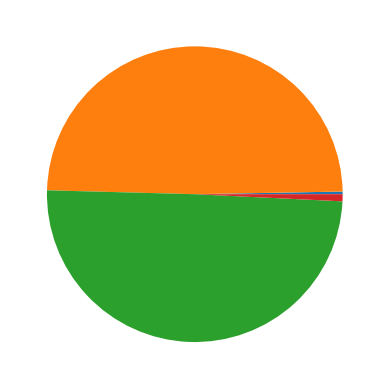

In [61]:
n.generators.p_nom_opt
plt.pie(n.generators_t.p.sum())
n.generators_t.p.sum()

In [45]:
#plt.pie(n.generators_t.p.sum())
tot_gen = pd.DataFrame()
tot_gen.loc[0, "solar_ff"] = max(n.generators_t.p["solar_S_ff"].sum() - n.generators_t.p["grid_export"].sum(), 0)
tot_gen.loc[0, "import"] = float(n.generators_t.p["grid_import"].sum())
#tot_gen.loc[0, "export"] = float(n.generators_t.p["grid_export"].sum())
tot_gen.loc[0, "CHP"] = float(-n.links_t.p1.sum().sum() + (n.generators_t.p["solar_S_ff"].sum() - n.generators_t.p["grid_export"].sum()))
tot_gen
plt.pie(
    tot_gen.iloc[0],
    labels=tot_gen.iloc[0].index,   # column names as labels
    autopct="%1.1f%%",     # show percentages
    startangle=90
)

KeyError: 'grid_import'

In [92]:
# Calculate costs
storage_capital_costs = (n.storage_units['capital_cost'] * (n.storage_units['p_nom_opt'])).groupby(n.storage_units['carrier']).sum()
storage_marginal_costs = (n.storage_units['marginal_cost'] * n.storage_units_t.p.sum(axis=0)).groupby(n.storage_units['carrier']).sum()
generators_capital_costs = (n.generators['capital_cost'] * (n.generators['p_nom_opt'])).groupby(n.generators['carrier']).sum()
generators_marginal_costs = (n.generators['marginal_cost'] * n.generators_t.p.sum(axis=0)).groupby(n.generators['carrier']).sum()
link_capital_costs = n.links['capital_cost'] * (n.links['p_nom_opt']).groupby(n.links['carrier']).sum()
link_marginal_costs = n.links['marginal_cost'] * n.links_t.p0.sum(axis=0).groupby(n.links['carrier']).sum()

# Combine costs into a single DataFrame
capital_costs = (
    storage_capital_costs
    .add(generators_capital_costs, fill_value=0)
    .add(link_capital_costs, fill_value=0)
)

marginal_costs = (
    storage_marginal_costs
    .add(generators_marginal_costs, fill_value=0)
    .add(link_marginal_costs, fill_value=0)
)
costs_df = pd.DataFrame({
    "Capital costs": capital_costs,
    "Marginal costs": marginal_costs
}).T

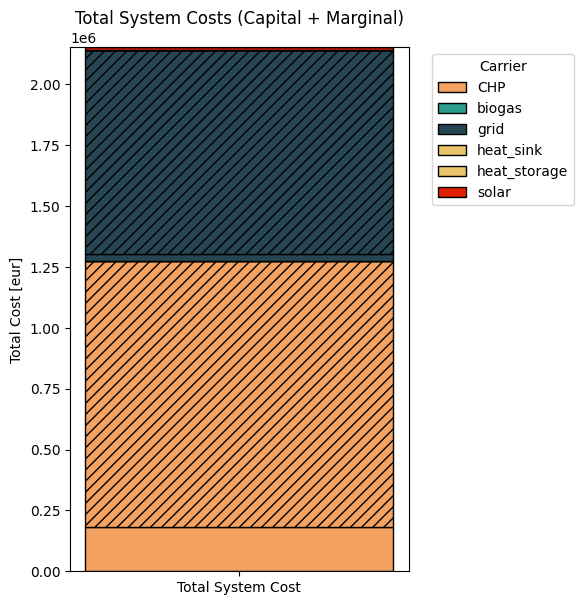

In [109]:
# --- Combine data ---
# assuming you already have these Series:
# capital_costs, marginal_costs

carriers = capital_costs.index
colors = ['#f4a261', '#2a9d8f', '#264653', '#e9c46a', '#e9c46a','#e11f01'][:len(carriers)]

# --- Plot setup ---
fig, ax = plt.subplots(figsize=(6,6))

bottom = 0
bars = []

for carrier, color in zip(carriers, colors):
    cap = capital_costs[carrier]
    mar = marginal_costs.get(carrier, 0)

    # Capital cost (solid color)
    bar_cap = ax.bar(0, cap, bottom=bottom, color=color, edgecolor='black')
    bottom += cap

    # Marginal cost (same color, hatched)
    bar_mar = ax.bar(0, mar, bottom=bottom, color=color, edgecolor='black', hatch='///')
    bottom += mar

    bars.append(bar_cap)

# --- Style and labels ---
ax.set_xticks([0])
ax.set_xticklabels(["Total System Cost"])
ax.set_ylabel("Total Cost [eur]")
ax.set_title("Total System Costs (Capital + Marginal)")

# Legend: one entry per carrier
legend_labels = [f"{carrier}" for carrier in carriers]
ax.legend(bars, legend_labels, title="Carrier", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


In [98]:
len(carriers)

6